# Graphene Constriction Simulation Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from scipy.ndimage import gaussian_filter
import os

In [3]:
class processHydroSim:
    '''
    processes a single simulation of hydrodynamic electron flow through a graphene constriction
    one simulation may constists of several run in parallel'''
    
    def __init__(self, directory, fname, verbose=True, minRunTime=0):
        
        self.directory = directory
        self.fname = fname
        self.filePath = './'+self.directory+'/'+self.fname+'/'
        self.verbose = verbose
        self.minRunTime = minRunTime

        
        # 2d plotting parameters
        self.symm = False
        self.blur =.3
        
        self.SD = 1.02 # NOTE this is not the SD set by the simulation; 
        #we are free to set this to achieve a given linear response from a SDratio=1 simulation
        self.resolution = .1 # this is not saved by simulation as before 2/2/22

        # source and drain locations; source is below constriction
        self.drainLoc = [0,1]
        self.sourceLoc= [0,-1]
        
        # get number of parallel simulations in filePath
        files=os.listdir(self.filePath)
        NPZfiles=[file for file in files if "npz" in file]
        self.Nsims=len(NPZfiles)
        
        self.loadInData()
        self.set_analysisType()
        
        self.removeFicticousEdges() # in the case of islands or a probe tip
        
        
    def set_analysisType(self):
    # determines how we analyze to tabulate particles to calculate voltages and currents
        if self.SDratio==1.:
            self.analysisType = 'linear response'
        else:
            self.analysisType = 'data as simulated'
    
    
    def loadInData(self):
        #loads in Nsim npz simulation files located in filePath
        excluded_string = ''
        
        for i in range(self.Nsims):
            with np.load('./'+self.filePath+'/'+self.fname+'_%03d.npz'%i) as mat:
            # load in the simulation objects saved as arrays inside an npz file
                if i == 0:

                    # these should be fixed for a given simulation batch
                    self.borderX = mat['borderX']
                    self.borderY = mat['borderY']
                    self.boxL = mat['boxL']
                    self.edgeStyle = mat['edgeStyle']
                    self.histX = mat['histX']
                    self.histY = mat['histY']
                    #self.resolution = mat['fieldResolution'] not in mat for some reason
                    self.stepSize = mat['DeltaX']
                    self.timesteps= mat['timeCount']
                    self.initializationT = mat['initializationCount']
                    self.SDratio = mat['sourceDrainRatio']
                    self.temp = mat['Temp']
                    self.simPartDensity = mat['simPartDensity']
                    self.expPartDensity = mat['expPartDensity']
                    self.pScatter =mat['p_scatter']
                    self.area =mat['Area']
                    self.emin =mat['Emin']
                    self.Npart = mat['Npart']
                    self.contacts = mat['contactLookUp']
                    self.currentMatrix = mat['currentMatrix']
                    self.transportMap = mat['transportMap']
                    self.drainsList = mat['drains']
                    self.sourcesList = mat['sources']
                    self.lengths = mat['lengths']
                    self.contactLengths = mat['lengths'][np.sort(np.append(self.drainsList,self.sourcesList))]
                    
                    # flags simulations if no parallel simulations run sufficently long enough
                    if mat['timeCount']<self.minRunTime:
                        excluded_string += f'exluded {self.fname}, runs: {i}'
                        self.flag= 1 
                        continue
                    else:
                        self.flag = 0
                    
                    self.Erho = mat['Erho'].copy()
                    self.rho = mat['rho'].copy()
                    self.vX = mat['Px'].copy()
                    self.vY = mat['Py'].copy()
                    self.ptcFlux = mat['Nabsorbed']-mat['Ninjected']
                    self.nInjections= mat['Ninjected']
                    self.nAbsorbtions = mat['Nabsorbed']
                    self.totalAbsorbed = sum(self.nAbsorbtions[self.drainsList])
                    self.transportMap += mat['transportMap']
                    self.currentMatrix += mat['currentMatrix']

                else: 
                    
                    if mat['timeCount']<self.minRunTime:
                        if excluded_string == '':
                            excluded_string += f'exluded {self.fname}, runs: {i}'
                        else:
                            excluded_string += f',{i}'
                        continue
                    else:
                        self.flag = 0
    
                    self.Erho += mat['Erho']
                    self.rho += mat['rho']
                    self.vX  += mat['Px']
                    self.vY  += mat['Py']
                    self.ptcFlux += mat['Nabsorbed']-mat['Ninjected']
                    self.nInjections += mat['Ninjected']
                    self.nAbsorbtions += mat['Nabsorbed']
                    self.totalAbsorbed += sum(self.nAbsorbtions[self.drainsList])
                    #self.currentMatrix += mat['currentMatrix']
                    #self.transportMap += mat['transportMap']
                    self.timesteps +=mat['timeCount']

        if excluded_string!='':
            print(excluded_string)
     
    def removeFicticousEdges(self):
    # inserts NaN for fictisious edges, so that they are not plotted
    
        f=-2
        for edge_idx in np.arange(len(self.edgeStyle)):
            idx_dif = len(self.borderX)-len(self.edgeStyle)  # difference between '' which changes with additions of NaNs
            edge = self.edgeStyle[edge_idx]
            if edge == f:
                self.borderX = np.insert(self.borderX,edge_idx + idx_dif, np.NaN)
                self.borderY = np.insert(self.borderY,edge_idx + idx_dif, np.NaN)
              
            
    def make_colorMesh_plot(self, axis, tw0D_histogram, m1):
    # 2d plot assigns colors to gridpoints of histX, histY according to twoD_histogram and vmin and vmax
        symm =self.symm
        if symm: 
        # if symmetric device, average the histogram over its halves
            tw0D_histogram+=tw0D_histogram[:,::-1]
            tw0D_histogram/=2
        axis.pcolormesh(self.histX,self.histY,tw0D_histogram,cmap = 'gray')#, vmin = .00001*m1,vmax = 2*m1)
        axis.axis('off')
        axis.plot(self.borderX,self.borderY,'r')
        #self.fig1.colorbar(tw0D_histogram,ax=axis)

        # plot source and drain edges with red and green markers
        for iD in self.drainsList:
            axis.plot((self.borderX[iD+1]+self.borderX[iD])/2,(self.borderY[iD+1]+self.borderY[iD])/2,'r.', markersize=15)
        for iS in self.sourcesList:
            axis.plot((self.borderX[iS+1]+self.borderX[iS])/2,(self.borderY[iS+1]+self.borderY[iS])/2,'g.', markersize=15)        

    def plot_densityAndVelocity(self):

        blur =0.3 # when averaging 2d histogram, blur sets weights of neighbors
        sigma = 0 # also related to averaging neighbors 

        self.fig1 = plt.figure(figsize = (15,10))
        ax0 = self.fig1.add_subplot(231)
        ax1 = self.fig1.add_subplot(232)
        ax2 = self.fig1.add_subplot(233)
        ax3 = self.fig1.add_subplot(234)
        ax4 = self.fig1.add_subplot(235)

        sliceIdx = 60
        
        #ax0 plots the energy density/particle density
        erho_uponRho_Plot = gaussian_filter(self.Erho.T,blur)/gaussian_filter(self.rho.T,blur)*(self.rho.T>0)
        rhoPlot =gaussian_filter(self.rho.T,blur)*(self.rho.T>0)
        m1 = np.median(np.concatenate([row[np.where(row>0)] for row in rhoPlot]))
        self.make_colorMesh_plot(ax0, rhoPlot, m1)

        #ax1 plots the horizontal velocity distribution
        vXplot = gaussian_filter(self.vX.T,blur)
        m1 = np.max(np.abs(vXplot))
        self.make_colorMesh_plot(ax1, vXplot, m1)
        #ax1.plot(3*np.ones(),self.histY, '--',markersize =14)

        #ax2 plots the vertical velocity distribution
        vYplot = gaussian_filter(self.vY.T,blur)
        m1 = np.max(np.abs(vYplot))
        self.make_colorMesh_plot(ax2, vYplot, m1)

        # velocity magnitude
        vMagPlot = (vXplot**2+vYplot**2)**.5
        m1 = np.max(vMagPlot)
        self.make_colorMesh_plot(ax3, vMagPlot, m1)

        # y velocity across constriction
        vXslice = vXplot[25:50,sliceIdx]
        ax4.plot(vXslice)
        ax4.set_xlabel('y position')
        ax4.set_ylabel('x velocity')

        ax0.set_title('voltage? map')
        ax1.set_title('horizontal velocity')
        ax2.set_title('vertical velocity')
        ax3.set_title('velocity magnitude')
        ax4.set_title('y velocity slice (above)')
        ax4.set_yticklabels([])
        ax4.set_xticklabels([])
        
        ax0.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax0.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        ax1.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax1.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        ax2.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax2.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        ax3.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax3.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        
        self.fig1.suptitle(f'Temp{self.temp}, density{np.round(self.simPartDensity,1)}')
        
    plt.show()

            
    def plot_reinjectionMaps(self):
    # plots N density maps for particles emenating from a specific contact
    # plots N absorbtion histograms for emanating from a specific contact
        
        contactList = ['head_31', 'tail_10', 'tail_8', 'tail_6', 'tail_4']
        blur=0.3
    
        # plot particle density reinjection from a contact
        self.fig2, ax2 = plt.subplots(len(contactList), 2, constrained_layout=True, figsize=[10,20])
        self.fig2.suptitle(f'Transport Maps (after reinjection from ...), T={self.temp}, nSim={self.simPartDensity}', size=15)

        for i,ptcMap in enumerate(self.transportMap):
            transportPlot =gaussian_filter(ptcMap.T,blur)*(ptcMap.T>0)
            m1 = np.median(np.concatenate([row[np.where(row>0)] for row in transportPlot]))
            ax2[i,0].pcolormesh(self.histX,self.histY,transportPlot,cmap = 'gray', vmin = 0.000001*m1,vmax = 1.999999*m1)
            ax2[i,0].plot(self.borderX,self.borderY,'r')
            ax2[i,0].axis('equal')
            ax2[i,0].axis('off')
            ax2[i,0].set_title(contactList[i])
            ax2[i,0].set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
            ax2[i,0].set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])

            #generates histograms showing distribution of particles absorbtion
            ax2[i,1].plot(contactList, (self.currentMatrix)[i]/self.contactLengths, '.', markersize=14)
            ax2[i,1].set_ylim([0, 2*np.median(self.currentMatrix[i]/self.contactLengths)])
        plt.show()
    
    def get_drainDist(self):
        '''
        calculates the distribution of current through the drain contacts'''
        
        drainCurrent = self.ptcFlux[self.edgeStyle==1]
        self.drainCurrent = drainCurrent/np.sum(drainCurrent)
    
    def plot_currentDist(self):
        '''
        plots current distribution through drains'''
        
        drainsList = ['tail_10', 'tail_8', 'tail_6', 'tail_4']
        
        self.get_drainDist()
        
        plt.plot(drainsList, self.drainCurrent, '.', markersize=15, label=f'{self.temp} K')
        plt.title('drain current distribution')
    
    def calculateReinjectionProbs(self):
        # calculate all ohmic contacts probablities of being a reinjection site when SD=1 
        # can be input into future simulations to get proper physical when SD !=1
        
        totalReinjections = np.sum(self.nInjections)
        probs = self.nInjections[0:self.nDeviceEdges]/totalReinjections

        nTipEdges = len(self.nInjections)-self.nDeviceEdges
        probs = np.append(probs, np.zeros(nTipEdges))
        self.probs = [round(prob, 8) for prob in probs ]

        
    def define_voltageGrid(self, location):
        # location = [x0,y0] 
        # give indicies  of gridpoints centered about location correponds
        
        # list of x and y points centered around location=[x0, y0]
        # [-.1 ,.19] offsets from [x0.y0] to give a 5x5 grid with .1um side lengths to average from
        Xpoints = np.arange(location[0]-.1,location[0]+.19,self.resolution)
        Ypoints = np.arange(location[1]-.1,location[1]+.19,self.resolution)
 
        # 2-d arrays with x and y coordinate for each gridpoint
        Xgrid, Ygrid = np.meshgrid(Xpoints, Ypoints)

        # compute "gridpoint indicies" of [y,x] of  by counting number of gridpoints from topmost or leftmost edges of box
        idxs = np.concatenate(np.array([(Ygrid+self.boxL/2)/self.resolution,(Xgrid+self.boxL/2)/self.resolution]).T)
        return idxs
        
        
    def measure_ptcCount_woTransportMap(self, location):
        # location = [x0,y0] 
        # measure the particle density at the given location by averaging particle count in a window
        
        idxs = self.define_voltageGrid(location)
        
        # calculate particle density in contacts
        ptcCount =[]
        #vGrid = gaussian_filter(rho.T,sigma=0)/gaussian_filter(Erho.T,sigma=0)
        ptcGrid =gaussian_filter(self.rho.T,sigma=0)
        for yxIdx in idxs:
        # find and store particle count at gridpoint at point with yIdx, xIdx
            yIdx,xIdx = int(yxIdx[0]), int(yxIdx[1])
            ptcCount = np.append(ptcCount, ptcGrid[yIdx, xIdx])
            
        self.ptcCount_total = np.sum(self.rho) # all contributions to rho (all particle counts)
        
        ptcCount_avg = np.average(ptcCount[ptcCount>0])
        return ptcCount_avg
    
    
    def measure_ptcCount_wTransportMap(self, location):
    # location = [x0,y0] 
    # measure the particle density at the given location by averaging a weighted particle count inside a window.
    
    # for each source/drain, the transport map keeps track of where particles are after reinjection
    # weight the transport maps by a sqrt(SD) for source reinjections and 1/sqrt(SD) for drain reinjectins
    # this keep total particles fixed, while summation computes particle count if fractionally (SD) more  emmanated from the source
    # all this gurantees we measure the linear response to applied voltage
    
        idxs = self.define_voltageGrid(location)
    
        ptcGrid =0
        for i,ptcMap in enumerate(self.transportMap): # ptcMap is ptcCounts after reinjection from ith conctat
            ptcHistogram =gaussian_filter(ptcMap.T,sigma=0) # build histogram from ptcmap
            if self.contacts[i] in self.drainsList: # reinjection from drain
                ptcGrid += 1/self.SD**.5*ptcHistogram
            else: #reinjection from source
                ptcGrid += self.SD**.5*ptcHistogram    
        
        ptcCount =[]
        for yxIdx in idxs:
        # find and store particle count at gridpoint at point with yIdx, xIdx
            yIdx,xIdx = int(yxIdx[0]), int(yxIdx[1])
            ptcCount = np.append(ptcCount, ptcGrid[yIdx, xIdx])
            
        self.ptcCount_total = np.sum(self.rho) # all contributions to rho (all particle counts)
        #THIS IS SOMETHING TO CHECK: MAKE SURE SUM(RHO) SAME AS SUM(PTCGRID)
        
        ptcCount_avg = np.average(ptcCount[ptcCount>0])
        return ptcCount_avg
    
    
    def measure_voltage(self):
    
        hbar, e, vF = 1.06e-34,1.6e-19, 1e6 # hbar, electron charge, fermi velocity in graphene, vF = 1.06e-34,1.6e-19, 1e6 # hbar, electron charge, fermi velocity in graphene
        timestepToSeocnd_ratio=(self.stepSize*1e-6)/vF
        
        '''# check the analysis type to determine how we calculate particle counts
        if self.analysisType=='linear response':
            ptcCount_source = self.measure_ptcCount_wTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_wTransportMap(self.drainLoc)
        elif self.analysisType== 'data as simulated':
            ptcCount_source = self.measure_ptcCount_woTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_woTransportMap(self.drainLoc)
        
        Ntot = self.ptcCount_total 
        # compute simulation density by comparting ratio of voltageGrid area to device's total area
        # here .1 is a the length of voltageGrid edge
        self.nSource= ptcCount_source*self.area/(.1**2*Ntot)*self.simPartDensity
        self.nDrain= ptcCount_drain*self.area/(.1**2*Ntot)*self.simPartDensity
        
        hbar, e, vF = 1.06e-34,1.6e-19, 1e6 # hbar, electron charge, fermi velocity in graphene
 
        # measure voltage across constriction by computing Fermi energy difference / e
        # exp density in 1/cm^2
        self.voltage = hbar*np.sqrt(np.pi)*vF/(2*e)*(self.nSource-self.nDrain)*((self.expPartDensity*1e4)**.5/self.simPartDensity)'''
        
        # computes densities from the number of injected particles
        
        w_source = np.sum(self.lengths[self.sourcesList])
        w_drain = np.sum(self.lengths[self.drainsList])
        N_inj_source = np.sum(self.nInjections[self.sourcesList])
        N_inj_drain = np.sum(self.nInjections[self.drainsList])
        
        
        Delta_Density_flux=np.pi/vF/self.timesteps/timestepToSeocnd_ratio/vF*(N_inj_source/w_source-N_inj_drain/w_drain)
        self.voltage = hbar*np.sqrt(np.pi)*vF/(2*e)*(Delta_Density_flux)*((self.expPartDensity*1e4)**.5/self.simPartDensity)
        
        
    def measure_ptcFlux_wCurrentMatrix(self):
    # measure particles absorbed - injected at drains by if more come from source contacts     
    
    # the (i,j) element of current matrix tells us the number of particles 
    # ... absorbed at contact i after reinjection from contact j
    # for each drain, weight the absorbtions by a sqrt(SD) for source reinjections and 1/sqrt(SD) for drain reinjectins
    # this keep total particles fixed, while summation computes Nabsorbed if fractionally (SD) more  emmanated from the source
    # weight all reinjections from a drain by 1/SD
    # sum (absorptions - injections) over all reinjections and then sum over all drains
        
        ptcFlux = 0
        totalAbsorbed = 0
        for i,absorbtionData in enumerate(self.currentMatrix.T): #columns of currentMatrix are absorption data; rows are injection data
            if self.contacts[i] in self.drainsList: # sum over only drain (top) contacts

                # weight absorbtion data by sqrt(SD) if ptcs came from source, ie, if column j of self.currentMatrix.T is a source 
                # weight by 1/sqrt(SD) if came from drain
                absorbtions = [x*self.SD**.5 if (self.contacts[j] in self.sourcesList) else x/self.SD**.5 for j,x in enumerate(absorbtionData) ]
                
                injections = self.currentMatrix[i]/self.SD**.5 # weight all injections by drain density percent

                ptcFlux += sum(absorbtions)-sum(injections)

                totalAbsorbed = sum(absorbtionData) # we also keep track of total aborsbed (no weighting) at the drains
                # we noticed this scales with sqrt(simulaiton density) strangely
                
        self.totalAbsorbed = totalAbsorbed 
        self. ptcFlux = ptcFlux
        return self.ptcFlux 
        
    def measure_current(self):
    # count the number of ptcs abosrbed - injected at drains and computes equivlant charge per second
        
        # check the analysis type to determine how we calculate particle flux through drain
        if self.analysisType=='linear response':
            ptcFlux = self.measure_ptcFlux_wCurrentMatrix()
        elif self.analysisType== 'data as simulated':
            ptcFlux = sum(self.ptcFlux[self.drainsList]) # load in from data and sum over drains

        # compute simulation partilces per timestep since statistics reset at self.initializationT
        if self.timesteps>self.initializationT:
            fluxPerT = np.sum(ptcFlux)/(self.timesteps-self.initializationT)
        else: 
            fluxPerT = np.sum(ptcFlux)/(self.timesteps)
    
        # density ratio = simulation charge: physical electron charge
        e, vF = 1.6e-19, 1e6 # electron charge, Fermi velocity in graphene
        
        #timestepToSeocnd_ratio= (self.stepSize*1e-6)/vF # sim ptcs travel 1e-8m/per timestep at speed vF
        timestepToSeocnd_ratio=(self.stepSize*1e-6)/vF
        
        self.current = e*fluxPerT*self.expPartDensity*1e-8/self.simPartDensity/timestepToSeocnd_ratio
    
    def calculate_resistance(self):
        self.resistance = self.voltage/self.current

        # calculates R without voltage,current induvivually
        '''if self.analysisType=='linear response':
            ptcFlux = self.measure_ptcFlux_wCurrentMatrix()
        elif self.analysisType== 'data as simulated':
            ptcFlux = sum(self.ptcFlux[self.drainsList]) # load in from data and sum over drains

        # compute simulation partilces per timestep since statistics reset at self.initializationT
        if self.timesteps>self.initializationT:
            fluxPerT = np.sum(ptcFlux)/(self.timesteps-self.initializationT)
        else: 
            fluxPerT = np.sum(ptcFlux)/(self.timesteps)
            
        # check the analysis type to determine how we calculate particle counts
        if self.analysisType=='linear response':
            ptcCount_source = self.measure_ptcCount_wTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_wTransportMap(self.drainLoc)
        elif self.analysisType== 'data as simulated':
            ptcCount_source = self.measure_ptcCount_woTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_woTransportMap(self.drainLoc)
        
        Ntot = self.ptcCount_total 
        # compute simulation density by comparting ratio of voltageGrid area to device's total area
        # here .1 is a the length of voltageGrid edge
        self.nSource= ptcCount_source*self.area/(.1**2*Ntot)*self.simPartDensity
        self.nDrain= ptcCount_drain*self.area/(.1**2*Ntot)*self.simPartDensity
        
        hbar, e, vF = 1.06e-34,1.6e-19, 1e6 # hbar, electron charge, fermi velocity in graphene
 
        self.resistance = .364*1e6*(self.nSource-self.nDrain)/fluxPerT/(self.expPartDensity)**.5'''
        
    def save(self):
        # save the relevant quantities and parameters into dictionaries
        self.get_drainDist()
        self.measure_voltage()
        self.measure_current()
        self.calculate_resistance()
        
        self.parameters = {'temp': self.temp, 'SDratio': self.SDratio, 'timesteps':self.timesteps, 'partDensity':self.simPartDensity, 'pScatter': self.pScatter, 'Emin': self.emin, 'Npart':self.Npart}# #'contacts': self.contacts}
        self.quantities={'voltage':self.voltage, 'current': self.current, 'resistance': self.resistance, 'totalAbsorbed': self.totalAbsorbed, 'currentDist': self.drainCurrent}

    

In [4]:
class storeAndAnalyze_simBatch():
    '''this stores the relevant quantities from each simulation in a batch located insdie directory
    also contains functions to perform subseqent analysis on the entire batch
    a batch is where we have set of simulations where each differs from the others in one parameter such as temperature'''
    
    def __init__(self, directory, minRunTime=0):
        
        self.data={}
        self.minRunTime = minRunTime
        self.directory = directory
        self.storeData_inDict()


    def processHydroSim_protocol(self, fname, i):
    # this defines the procedure for processing a single simulation in the batch
    # we use functions from the processHydroSim class
        sim = processHydroSim(self.directory, fname, minRunTime=self.minRunTime)
        
        if sim.flag == 1:
            pass
        else:
            
            sim.save()
            if i==0:
                #sim.plot_densityAndVelocity()
                #sim.plot_reinjectionMaps()
                plt.show()

        return sim
            
        
    def storeData_inDict(self):
    # store the parameters and quantities of all processed simulations of one bactch into the self.data dictionary
        
        fnameBases = os.listdir(self.directory)
        i=0
        for fname in fnameBases:
            path = './'+self.directory+'/'+fname
            try:
                if os.path.isdir(path):

                    sim = self.processHydroSim_protocol(fname, i) # defines class for one simulation
                    if sim.flag == 1:
                        print(f'{fname} flagged')
                        continue

                    # move paramaters/quantitities from the induvidual simulation dictionary into the batch dictionary 
                    for p in sim.parameters:
                        if i ==0:
                            self.data[p]=[]
                        self.data[p] = np.append(sim.parameters[p],self.data[p])

                    for q in sim.quantities:
                        if i ==0:
                            self.data[q]=[]
                        self.data[q] = np.append(sim.quantities[q],self.data[q])
                    i+=1

                else:
                    pass

            except:
                print(f'Error for {fname}')
                pass
            
        print(f'loaded {i} simulations')
        
    def form_constantZsubset(self, zConstants, xLabel='temp'):
    # forms a boolean array of length self.data
    # zConstant has the form [[zLabel1, constant1], ... [zLabelN, constantN]]
    # true element if z parameters in the set are equal to the speicifed constant
    
        if zConstants==[]: # if no constant parameters specified, include all simulations
                constantZsubset = np.ones(len(self.data[xLabel]), dtype='bool')
        else:
            for i,zConstant in enumerate(zConstants):
                    if i==0:
                        constantZsubset = self.data[zConstant[0]]==zConstant[1]
                    else:
                        constantZsubset *= self.data[zConstant[0]]==zConstant[1]
                
        return constantZsubset
            
    def plot_xVsYi_allZfixed(self,xLabel, yLabel_0, yLabel_1toN=[], zConstants=[]):
    # plot parameter x vs qunatity y0 for constant z variables; also plot y1,..., yN weighted to have y0 average
    # xLabel and yLabel are strings
    # yLabel_N gives N additional labels
    
        constantZsubset = self.form_constantZsubset(zConstants)

        x = self.data[xLabel][constantZsubset]
        y0 = self.data[yLabel_0][constantZsubset]
        
        plt.figure(figsize=(6,8))
        plt.plot(x, y0,'.', label=yLabel_0)
        
        # weight each yi appropriately and plot
        for i,yLabel_i in enumerate(yLabel_1toN):
            yi = self.data[yLabel_i][constantZsubset]
            yi = yi*np.average(y0)/np.average(yi)
            plt.plot(x,yi,'.', label = yLabel_i)

        plt.xlabel(xLabel)
        plt.legend()
        #plt.title("0.5 um PC (current = nAbs-nInj)")
        
        
    def plot_xVsProductYi_allZfixed(self, xLabel, yLabel, powerLaw=[1,1], zConstants=[]):
    # plot the product of variables y0^power0 * ... * yN^powerN vs x for constant z variables
    # yLabel is a list of labels
    
        constantZsubset = self.form_constantZsubset(zConstants)
 
        x = self.data[xLabel][constantZsubset]
    
        # compute product of yi, over 0 to N
        for i,yLabel_i in enumerate(yLabel):
            if i ==0:
                y = self.data[yLabel[i]][constantZsubset]**powerLaw[0]
            else:
                y *= self.data[yLabel[i]][constantZsubset]**powerLaw[0]

        plt.figure(figsize=(6,8))
        plt.plot(x, y, '.', label=f'at {zConstant[0]}={zCosntant[1]}')

        plt.title(f'producut of {yLabel} raised respectively to {powerLaw}')
        plt.xlabel(xLabel)
        plt.legend()
        
        
    def plot_xVsProductYi_forEachZfixed(self,xLabel, yLabel, powerLaw=[1,1], zConstants=[]):
    # plot the product of two variables w^power0 * y^power1 vs x 
    # make one plot for constant z variable specified
    
        fig,ax = plt.subplots(figsize=(6,8))
        
        for zConstant in zConstants:
            constantZsubset = self.form_constantZsubset([zConstant])
            x = self.data[xLabel][constantZsubset]

            # compute product of yi, over 0 to N
            for i,yLabel_i in enumerate(yLabel):
                if i ==0:
                    y = self.data[yLabel_i][constantZsubset]**powerLaw[i]
                else:
                    y *= self.data[yLabel_i][constantZsubset]**powerLaw[i]

            ax.plot(x, y, '.', label=f' {zConstant[0]}={zConstant[1]}', markersize=12)

        ax.set_title(label=f'producut of {yLabel} raised respectively to {powerLaw}')
        ax.set_xlabel(xLabel)
        ax.legend()




Error for .ipynb_checkpoints
loaded 40 simulations


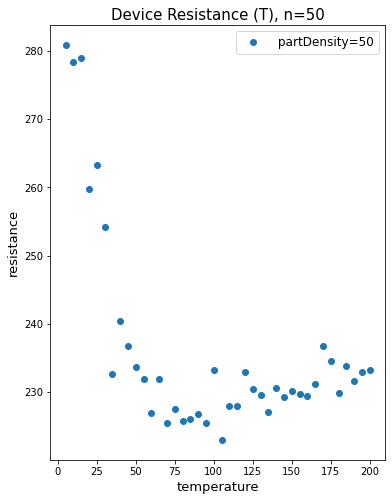

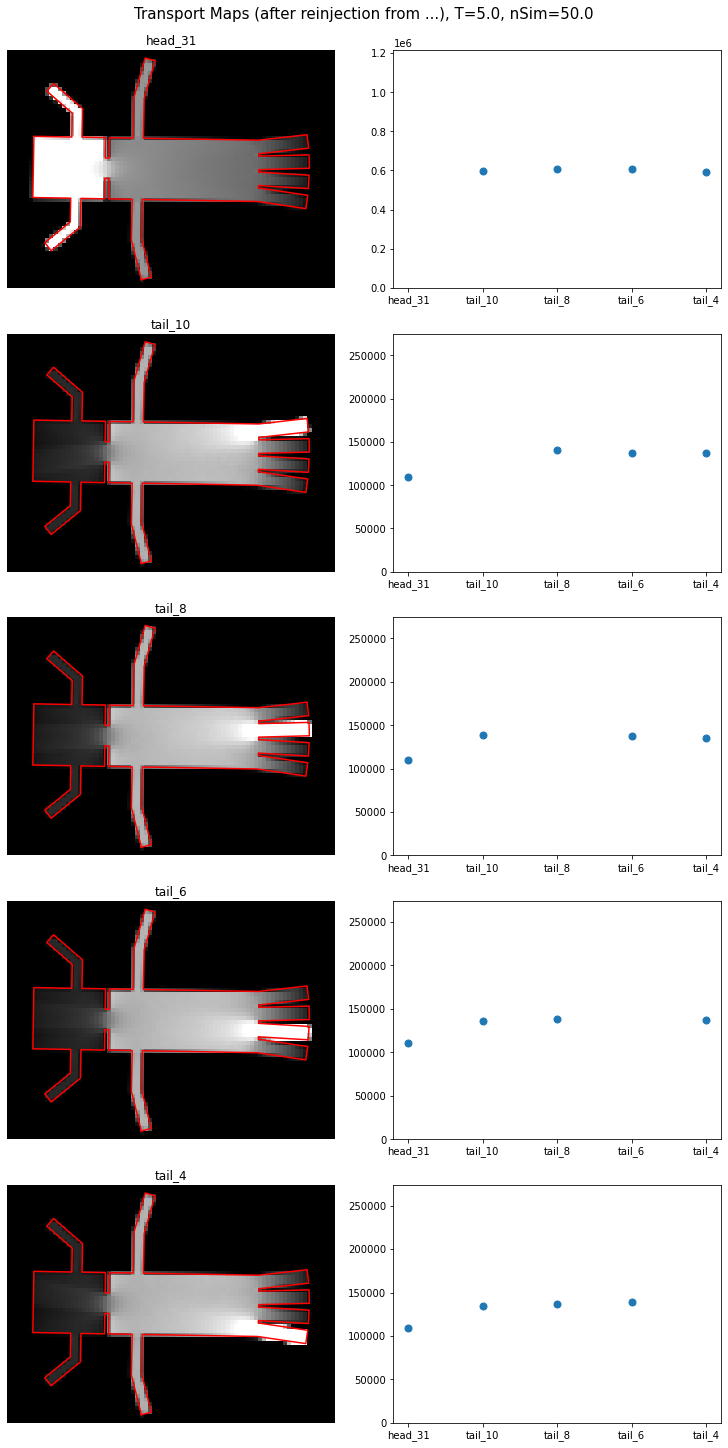

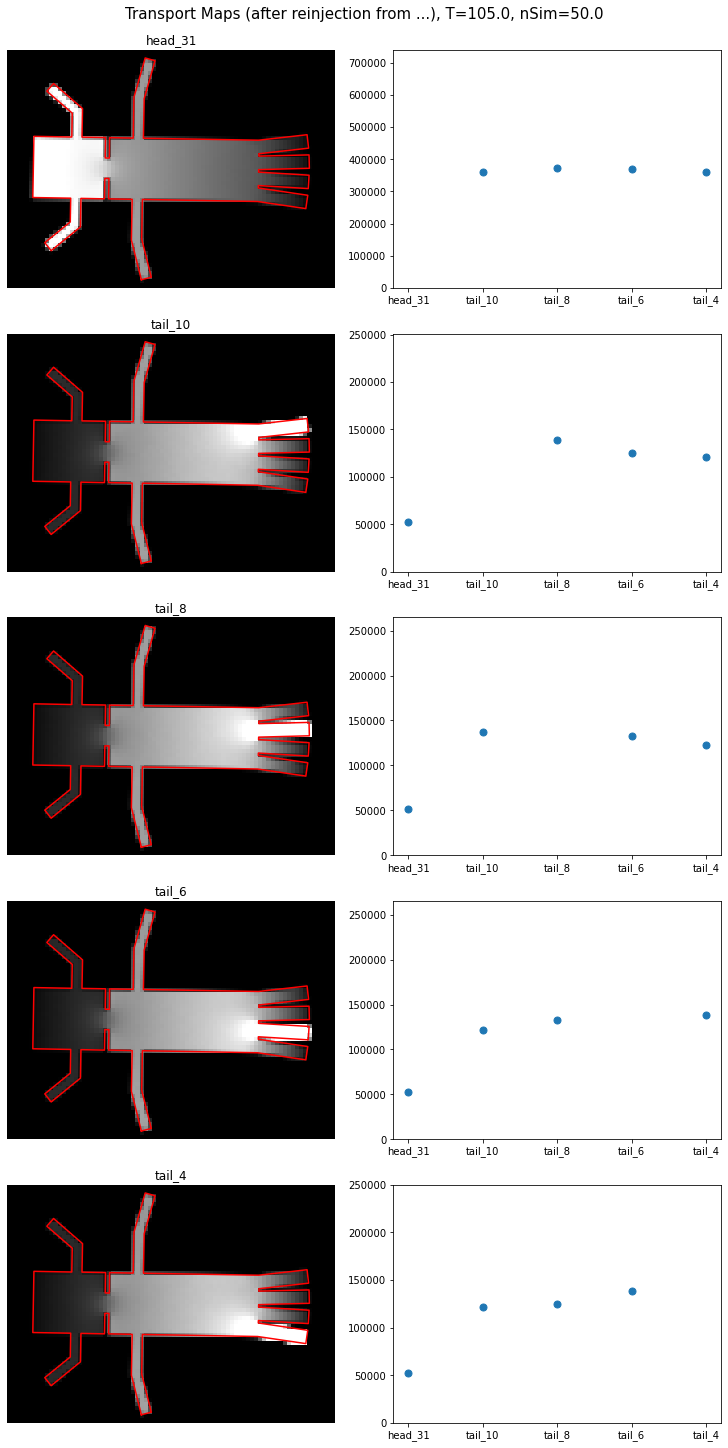

In [26]:
directory = '4-16-22_SD1.2_nExp2e12'
_4_16_22 = storeAndAnalyze_simBatch(directory)

yLabel = ['resistance']
powerLaw = [1]
zConstants =[['partDensity', 50]]

_4_16_22.plot_xVsProductYi_forEachZfixed('temp', yLabel, powerLaw=powerLaw, zConstants=zConstants)

plt.title("Device Resistance (T), n=50", size=15)
plt.ylabel('resistance', size=13)
plt.xlabel('temperature', size=13)
plt.legend(prop={"size":12})

T5_n50_noProbe = processHydroSim(directory, 'Axolotl_T5_n50')
T55_n50_noProbe = processHydroSim(directory, 'Axolotl_T55_n50')
T105_n50_noProbe = processHydroSim(directory, 'Axolotl_T105_n50')
T155_n50_noProbe = processHydroSim(directory, 'Axolotl_T155_n50')
T180_n50_noProbe = processHydroSim(directory, 'Axolotl_T180_n50')

sim = T5_n50_noProbe
sim.plot_reinjectionMaps()
sim = T105_n50_noProbe
sim.plot_reinjectionMaps()

loaded 24 simulations


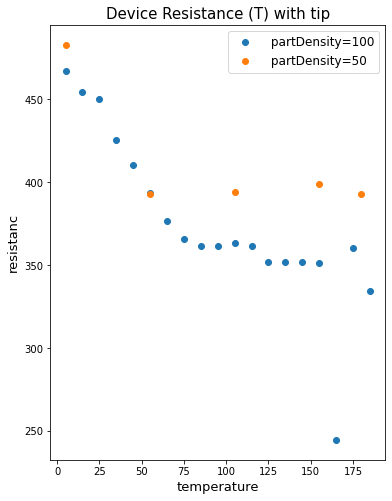

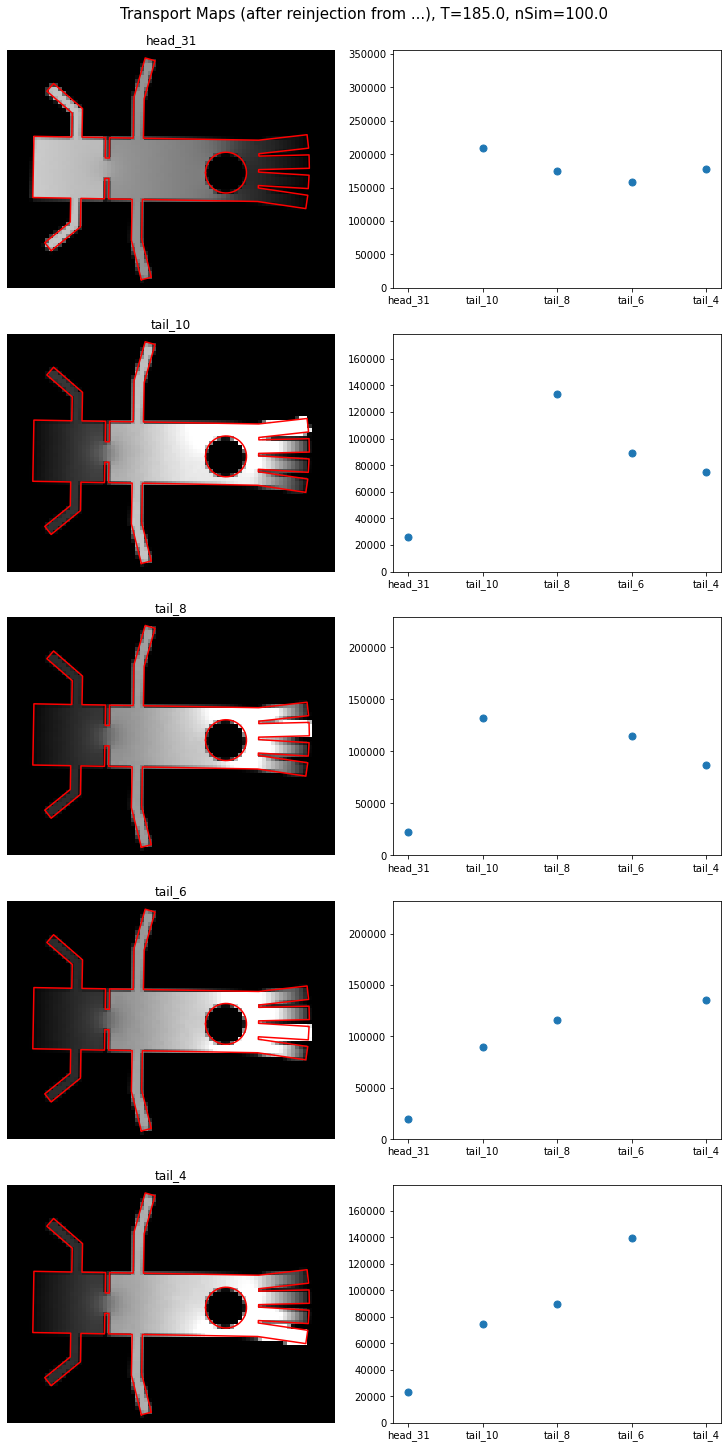

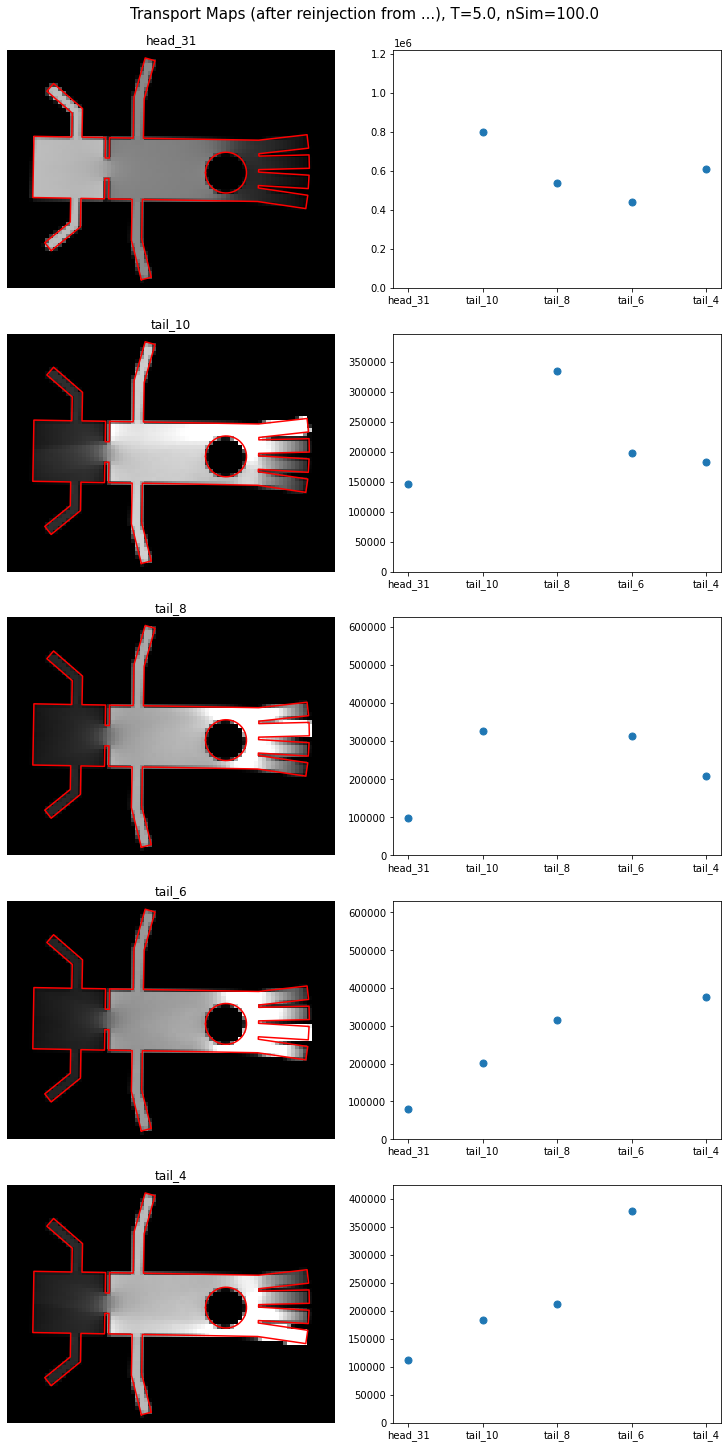

In [175]:
directory = '4-17-22_SD1.2_nExp2e12_probeTip'
_4_17_22 = storeAndAnalyze_simBatch(directory)

yLabel = ['resistance']
powerLaw = [1]
zConstants =[['partDensity', 100],['partDensity', 50]]

_4_17_22.plot_xVsProductYi_forEachZfixed('temp', yLabel, powerLaw=powerLaw, zConstants=zConstants)

plt.title("Device Resistance (T) with tip", size=15)
plt.ylabel('resistanc', size=13)
plt.xlabel('temperature', size=13)
plt.legend(prop={"size":12})

T5_n50_probe = processHydroSim(directory, 'Axolotl_T5_n50_tip1.4-0')
T55_n50_probe = processHydroSim(directory, 'Axolotl_T55_n50_tip1.4-0')
T105_n50_probe = processHydroSim(directory, 'Axolotl_T105_n50_tip1.4-0')
T155_n50_probe = processHydroSim(directory, 'Axolotl_T155_n50_tip1.4-0')
T180_n50_probe = processHydroSim(directory, 'Axolotl_T180_n50_tip1.4-0')

T5_n100_probe = processHydroSim(directory, 'Axolotl_T5_n100_tip1.4-0')
T25_n100_probe = processHydroSim(directory, 'Axolotl_T25_n100_tip1.4-0')
T35_n100_probe = processHydroSim(directory, 'Axolotl_T35_n100_tip1.4-0')
T55_n100_probe = processHydroSim(directory, 'Axolotl_T55_n100_tip1.4-0')
T75_n100_probe = processHydroSim(directory, 'Axolotl_T75_n100_tip1.4-0')
T105_n100_probe = processHydroSim(directory, 'Axolotl_T105_n100_tip1.4-0')
T155_n100_probe = processHydroSim(directory, 'Axolotl_T155_n100_tip1.4-0')
T185_n100_probe = processHydroSim(directory, 'Axolotl_T185_n100_tip1.4-0')

sim = T185_n100_probe
sim.plot_reinjectionMaps()

sim = T5_n100_probe
sim.plot_reinjectionMaps()

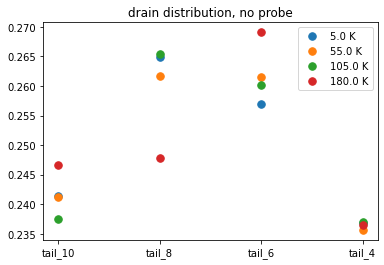

In [7]:
T5_n50_noProbe.plot_currentDist()
T55_n50_noProbe.plot_currentDist()
T105_n50_noProbe.plot_currentDist()
T180_n50_noProbe.plot_currentDist()
plt.title('drain distribution, no probe')

plt.legend()

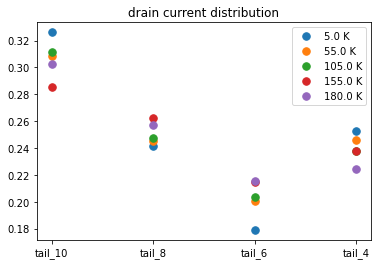

In [8]:
T5_n50_probe.plot_currentDist()
T55_n50_probe.plot_currentDist()
T105_n50_probe.plot_currentDist()
T155_n50_probe.plot_currentDist()
T180_n50_probe.plot_currentDist()
plt.legend()

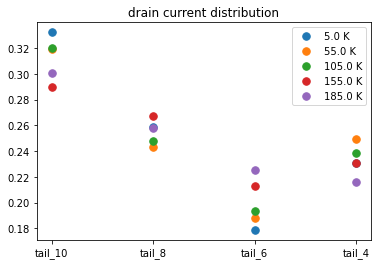

In [9]:
T5_n100_probe.plot_currentDist()
T55_n100_probe.plot_currentDist()
T105_n100_probe.plot_currentDist()
T155_n100_probe.plot_currentDist()
T185_n100_probe.plot_currentDist()
plt.legend()

Text(0.5, 1.0, 'drain distribution: highT with tip - lowT with tip')

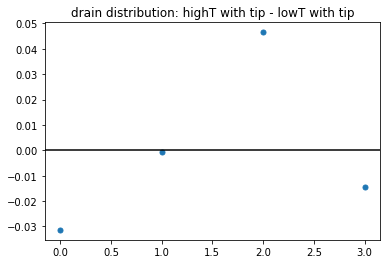

In [25]:
T185_n100_probe.save()
T180_n50_noProbe.save()

currentDist_T185_probe = T185_n100_probe.quantities['currentDist']
currentDist_T180_noProbe = T180_n50_noProbe.quantities['currentDist']

plt.plot(currentDist_T185_probe-currentDist_T5_probe, '.', markersize=10)
plt.axhline(0, color='black')
plt.title('drain distribution: highT with tip - lowT with tip')

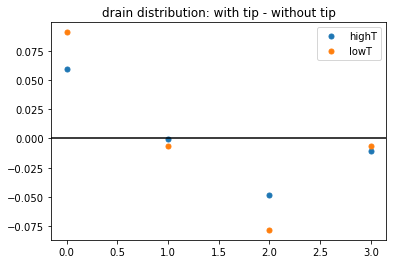

In [22]:
T155_n100_probe.save()
T155_n50_noProbe.save()
currentDist_T155_probe = T155_n100_probe.quantities['currentDist']
currentDist_T155_noProbe = T155_n50_noProbe.quantities['currentDist']

T5_n100_probe.save()
T5_n50_noProbe.save()
currentDist_T5_probe = T5_n100_probe.quantities['currentDist']
currentDist_T5_noProbe = T5_n50_noProbe.quantities['currentDist']



plt.plot(currentDist_T155_probe-currentDist_T155_noProbe, '.', markersize=10, label='highT')
plt.plot(currentDist_T5_probe-currentDist_T5_noProbe, '.', markersize=10, label='lowT')
plt.axhline(0, color='black')
plt.title('drain distribution: with tip - without tip')
plt.legend()

In [28]:
X,Y = T155_n100_probe.histX,T155_n100_probe.histY

vX_highT = T155_n100_probe.vX/np.sum(T155_n100_probe.vX)
vX_lowT = T5_n100_probe.vX/np.sum(T5_n100_probe.vX)
vX_medT = T55_n100_probe.vX/np.sum(T55_n100_probe.vX)

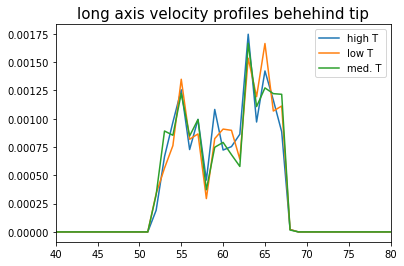

In [29]:
behindTip_idx = 82

plt.plot(vX_highT[behindTip_idx], label= 'high T')
plt.plot(vX_lowT[behindTip_idx], label= 'low T')
plt.plot(vX_medT[behindTip_idx], label='med. T')
plt.xlim(40,80)
plt.title('long axis velocity profiles behehind tip', size=15)
plt.legend()

/var/folders/2q/zwhp08x13v922d11l_dgr4t80000gn/T/ipykernel_93353/711168445.py:172: RuntimeWarning: invalid value encountered in true_divide
  erho_uponRho_Plot = gaussian_filter(self.Erho.T,blur)/gaussian_filter(self.rho.T,blur)*(self.rho.T>0)


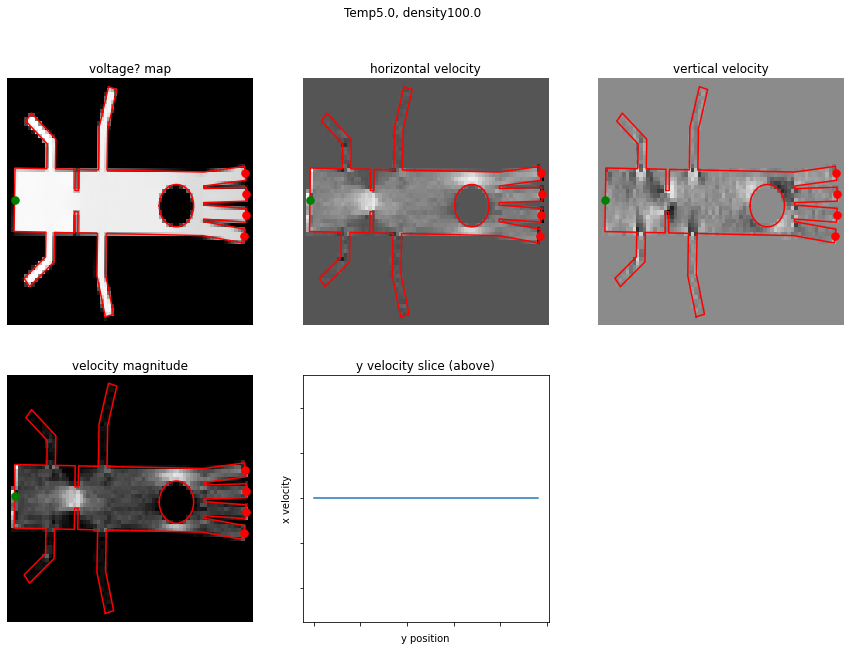

In [16]:
T5_n100_probe.plot_densityAndVelocity()

In [58]:
rho_highT = T155_n100_probe.rho/np.sum(T155_n100_probe.rho)
rho_lowT = T5_n100_probe.rho/np.sum(T5_n100_probe.rho)
rho_medT = T55_n100_probe.rho/np.sum(T55_n100_probe.rho)

(0.00084, 0.0009)

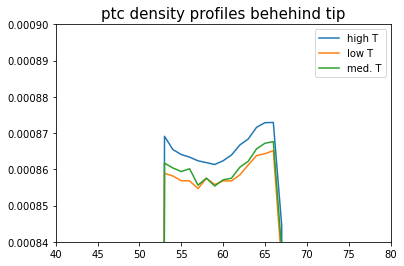

In [161]:
behindTip_idx = 80

plt.plot(rho_highT[behindTip_idx], label= 'high T')
plt.plot(rho_lowT[behindTip_idx], label= 'low T')
plt.plot(rho_medT[behindTip_idx], label='med. T')
plt.xlim(40,80)
plt.title('ptc density profiles behehind tip', size=15)
plt.legend()
plt.ylim((0.00084,0.0009))

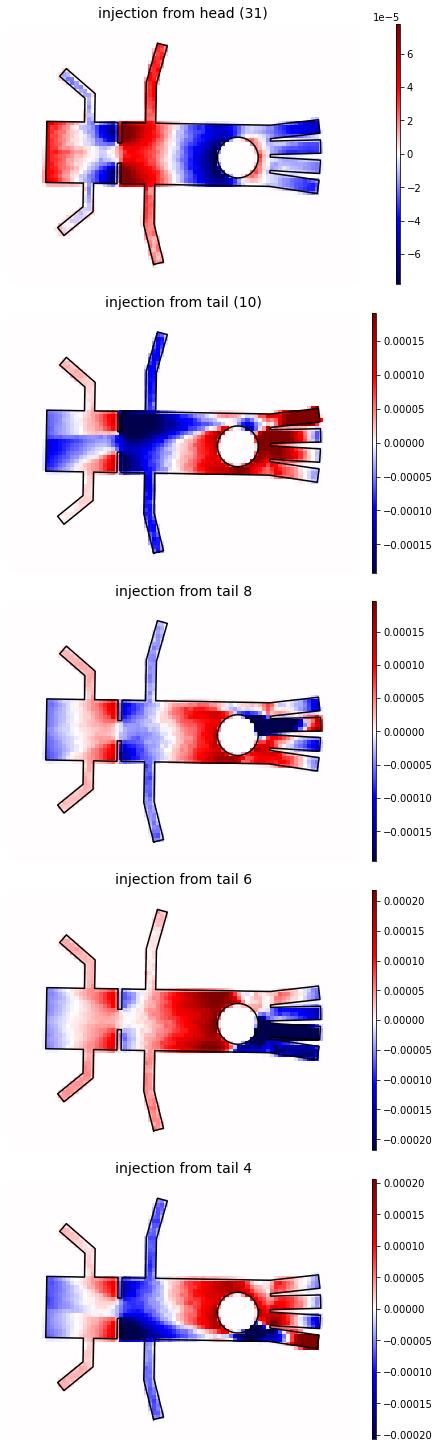

In [209]:
contactList = ['head (31)', 'tail (10)', 'tail 8', 'tail 6', 'tail 4']

# plot particle density reinjection from a contact
fig, ax = plt.subplots(len(contactList), constrained_layout=True, figsize=[6,20])

sim1 = T185_n100_probe
sim2 = T5_n100_probe
blur=0.3

for i,ptcMap1 in enumerate(sim1.transportMap):
    
    ptcMap2 = sim2.transportMap[i]
    transportPlot =gaussian_filter((ptcMap1/np.sum(ptcMap1)-ptcMap2/np.sum(ptcMap2)).T,blur)
    
    m1 = np.median(np.concatenate([row[np.where(row>0)] for row in transportPlot]))
    pc =ax[i].pcolormesh(sim1.histX,sim1.histY,transportPlot,cmap = 'seismic', vmin = -8*m1,vmax = 8*m1)
    ax[i].plot(sim1.borderX,sim1.borderY,'k')
    ax[i].axis('equal')
    ax[i].axis('off')
    ax[i].set_title('injection from '+contactList[i], size=14)
    ax[i].set_xlim([min(sim1.borderX)-.2, max(sim1.borderX)+.2])
    ax[i].set_ylim([min(sim1.borderY)-.2, max(sim1.borderY)+.2])
    fig.colorbar(pc, ax=ax[i])

(-2.8230000000000004, 3.008)

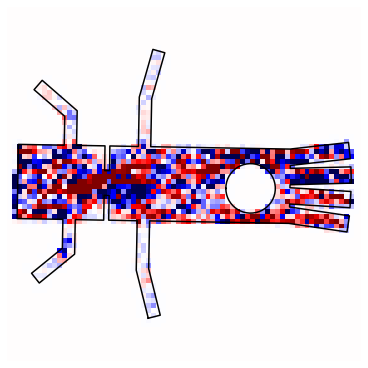

In [192]:
contactList = ['head_31', 'tail_10', 'tail_8', 'tail_6', 'tail_4']

# plot particle density reinjection from a contact
fig, ax = plt.subplots(1, constrained_layout=True, figsize=[5,5])

sim = T25_n100_probe
sim_noProbe = T5_n100_probe
blur=.3

ptcMap = (sim.vX**2+sim.vY**2)
ptcMap_noProbe = (sim_noProbe.vX**2+sim_noProbe.vY**2)
transportPlot =gaussian_filter((ptcMap/np.sum(ptcMap)).T-(ptcMap_noProbe/np.sum(ptcMap_noProbe)).T,blur)

m1 = np.median(np.concatenate([row[np.where(row>0)] for row in transportPlot]))
ax.pcolormesh(sim.histX,sim.histY,transportPlot,cmap = 'seismic', vmin = -8*m1,vmax = 8*m1)
ax.plot(sim.borderX,sim.borderY,'k')
ax.axis('equal')
ax.axis('off')
ax.set_title('')
ax.set_xlim([min(sim.borderX)-.2, max(sim.borderX)+.2])
ax.set_ylim([min(sim.borderY)-.2, max(sim.borderY)+.2])